# Testing Derivative Class

This notebook is where I test my new derivative class. There are two: 

1. This will take a KernelRidge model from a fully trained KRR model from the scikit-learn library that has been trained with my custom RBF kernel.
2. This will take a GP model

In [1]:
import warnings
warnings.simplefilter('ignore')

from dask.distributed import Client, LocalCluster
from dask_jobqueue import SLURMCluster

In [2]:
# cluster = LocalCluster(n_workers=1, 
#                        processes=False)

# cluster = SLURMCluster(memory="50GB",
#                        env_extra=['export LANG="en_US.utf8"',
#                                   'export LANGUAGE="en_US.utf8"',
#                                   'export LC_ALL="en_US.utf8"'],
#                        cores=1, job_cpu=16, walltime='3:00:00', name='derivative_test')
# # cluster = SLURMCluster(processes=1, cores=1, memory="150GB",
# #                        job_cpu=24, walltime='3:00:00', name='cross_preds')
# cluster.scale(1)
client = Client('192.168.2.18:51120')
# client = Client(address="nodo08:3008")
# client = Client(cluster)
address = client.scheduler.address

In [3]:
import sys
sys.path.insert(0, '/home/emmanuel/code/kernellib')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF
from kernellib.kernels import rbf_kernel
from kernellib.krr import KernelRidge
plt.style.use('ggplot')
%matplotlib inline

%load_ext memory_profiler
%load_ext autoreload

## Sample Data

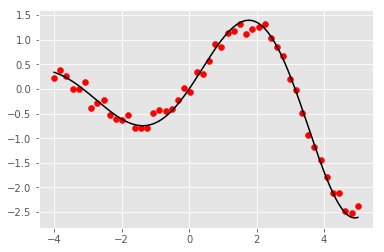

In [4]:
def sample_data():
    """Gets some sample data."""
    d_dimensions = 1
    n_samples = 50
    noise_std = 0.1
    seed = 123
    rng = np.random.RandomState(seed)


    n_train = 50
    n_test = 5000
    xtrain = np.linspace(-4, 5, n_train).reshape(n_train, 1)
    xtest = np.linspace(-4, 5, n_test).reshape(n_test, 1)

    f = lambda x: np.sin(x) * np.exp(0.2 * x)
    ytrain = f(xtrain) + noise_std * rng.randn(n_train, 1)
    ytest = f(xtest)

    return xtrain, xtest, ytrain, ytest

random_state = 0
rng = np.random.RandomState(random_state)

xtrain, xtest, ytrain, ytest = sample_data()

fig, ax = plt.subplots()

ax.scatter(xtrain, ytrain, color='r')
ax.plot(xtest, ytest, color='k')

plt.show()

### ARD Kernel Function

In [5]:
from sklearn.gaussian_process.kernels import RBF
from kernellib.kernels import ard_kernel

%autoreload 2

In [6]:
K = ard_kernel(xtrain, length_scale=1.0)
sk_ard_kernel = RBF(length_scale=1.0)
K_sk = sk_ard_kernel(xtrain)

np.testing.assert_array_almost_equal(K, K_sk, decimal=13)


In [7]:
%timeit -r 10 ard_kernel(xtrain, xtrain, length_scale=1.0)

114 µs ± 3.67 µs per loop (mean ± std. dev. of 10 runs, 10000 loops each)


In [8]:
%timeit -r 10 sk_ard_kernel(xtrain, xtrain)

80.4 µs ± 426 ns per loop (mean ± std. dev. of 10 runs, 10000 loops each)


In [9]:
X = np.random.randn(5000, 50)

In [10]:
%timeit ard_kernel(X, length_scale=1.0)

1.2 s ± 8.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit sk_ard_kernel(X)

680 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### GP Function

In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (ConstantKernel as C, RBF, WhiteKernel)

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
kernel = C() * RBF() + WhiteKernel()
gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, random_state=123, normalize_y=True)
gp_model.fit(xtrain, ytrain)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=5, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=123)

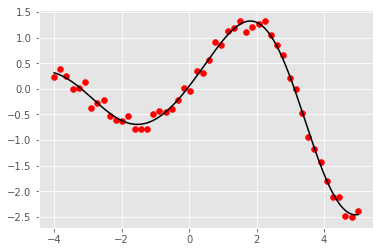

In [14]:
ypred = gp_model.predict(xtest)
fig, ax = plt.subplots()

ax.scatter(xtrain, ytrain, color='r')
ax.plot(xtest, ypred, color='k')

plt.show()

## Derivative

In [15]:
from kernellib.derivatives import ARDDerivative

%autoreload 2

In [16]:
ard_derivative = ARDDerivative(gp_model=gp_model)
der = ard_derivative(xtest)
point_sens = ard_derivative.sensitivity(xtest)
dim_sens = ard_derivative.sensitivity(xtest, sample='dim')
print(dim_sens)

print(ard_derivative.length_scale)

[0.86466304]
[1.73323923]


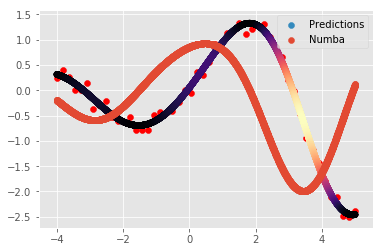

In [17]:
fig, ax = plt.subplots()

ax.scatter(xtrain, ytrain, color='r')
ax.scatter(xtest, ypred, c=point_sens.reshape(-1, 1), cmap=plt.get_cmap('magma'), label='Predictions')
ax.scatter(xtest, der,  label='Numba')

ax.legend()
plt.show()

In [73]:
from sklearn.datasets import load_boston
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

In [74]:
X, y = load_boston().data, load_boston().target

xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, random_state=123)
print(xtrain.shape, xtest.shape)

(404, 13) (102, 13)


In [79]:
%%time
# Initialize GP Model
kernel = C() * RBF() + WhiteKernel()
gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, random_state=None, normalize_y=True)
gp_model.fit(xtrain, ytrain)
ypred = gp_model.predict(xtest)

CPU times: user 59.3 s, sys: 7min 37s, total: 8min 36s
Wall time: 14.4 s


In [80]:
mse = mean_squared_error(ypred, ytest)
mae = mean_absolute_error(ypred, ytest)
r2 = r2_score(ypred, ytest)
print(mse, mae, r2)

14.61593995606758 2.603261802954389 0.808490572824327


In [81]:
from kernellib.derivatives import ARDDerivative

%autoreload 2

In [82]:
ard_derivative = ARDDerivative(gp_model=gp_model)
der = ard_derivative(xtest)
dim_sens = ard_derivative.sensitivity(xtest, sample='dim')

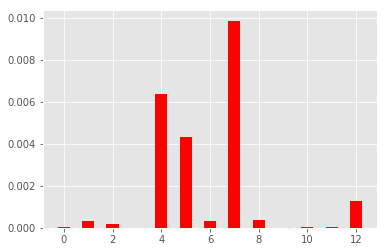

In [83]:
ind = np.arange(X.shape[1])  # the x locations for the groups
width = .5       # the width of the bars

fig, ax = plt.subplots()
gpr = ax.bar(ind, dim_sens, width, color='r', label='ARD')

plt.show()

In [84]:
%%time
# Initialize GP Model
init_scale = [1.0] * xtrain.shape[1]
kernel = C() * RBF(init_scale) + WhiteKernel()
gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, random_state=None, normalize_y=True)
gp_model.fit(xtrain, ytrain)
ypred = gp_model.predict(xtest)

CPU times: user 5min 20s, sys: 51min 55s, total: 57min 15s
Wall time: 1min 36s


In [85]:
mse = mean_squared_error(ypred, ytest)
mae = mean_absolute_error(ypred, ytest)
r2 = r2_score(ypred, ytest)
print(mse, mae, r2)

28.09311717950738 3.0128161991149054 0.5587446582723312


In [86]:
ard_derivative = ARDDerivative(gp_model=gp_model)
der = ard_derivative(xtest)
dim_sens = ard_derivative.sensitivity(xtest, sample='dim')

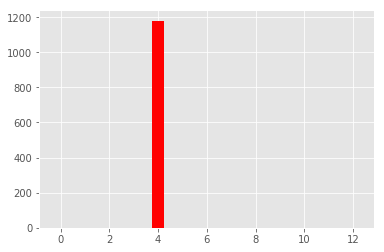

In [87]:
ind = np.arange(X.shape[1])  # the x locations for the groups
width = .5       # the width of the bars

fig, ax = plt.subplots()
gpr = ax.bar(ind, dim_sens, width, color='r', label='ARD')

plt.show()

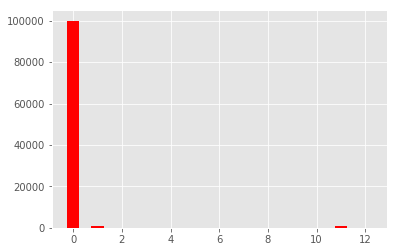

In [88]:
ind = np.arange(X.shape[1])  # the x locations for the groups
width = .5       # the width of the bars

fig, ax = plt.subplots()
gpr = ax.bar(ind, ard_derivative.length_scale, width, color='r', label='ARD')

plt.show()